In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
import sys
from pyne import nucname
from pyne.material import Material

/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/13b/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
# get sqlite cursor
filename = '../../db/1yr.sqlite'
con = lite.connect(filename)
# allows indexing with column name
con.row_factory = lite.Row
cur = con.cursor()

# Finding the Average Assembly and its Composition 

In [3]:
# first, find the average composition and recipe 
average_burnup = cur.execute('SELECT avg(discharge_burnup) FROM discharge').fetchone()[0]
average_enrichment = cur.execute('SELECT avg(initial_enrichment) FROM discharge').fetchone()[0]
print('AVG BURNUP: %f MWD/MTHM \nAVG ENRICHMENT: %f wt%% U235' %(average_burnup, average_enrichment))

AVG BURNUP: 36169.381303 MWD/MTHM 
AVG ENRICHMENT: 3.392045 wt% U235


In [4]:
# find assembly closest to this value:
min_diff_assem_id = cur.execute('SELECT assembly_id, min(abs(discharge_burnup - %f) + abs(initial_enrichment - %f)* 10000) '
                                'FROM discharge' %(average_burnup, average_enrichment)).fetchone()[0]
print(min_diff_assem_id)

324192


In [5]:
# how different is this assembly from the average?
chosen_assem = cur.execute('SELECT * FROM discharge WHERE assembly_id = %i' %min_diff_assem_id).fetchall()
burnup = chosen_assem[0]['discharge_burnup']
enrichment = chosen_assem[0]['initial_enrichment']

# print error with the average value:
print('ERROR:')
enr_err = 100 * (average_enrichment - enrichment) / average_enrichment
bur_err = 100 * (average_burnup - burnup) / average_burnup
print('ENRICHMENT: %f %% \nBURNUP %f %%' %(enr_err, bur_err))

ERROR:
ENRICHMENT: -0.057637 % 
BURNUP -0.007240 %


In [6]:
# save this assembly's composition to a dictionary
recipe = {}
total_mass = 0
for row in chosen_assem:
    isotope = nucname.name(row['isotope'])
    mass = float(row['total_mass_g'])
    total_mass += mass
    recipe[isotope] = mass

# normalize values:
for iso in recipe:
    recipe[iso] = recipe[iso] / total_mass


# We store all the assemblies in a dictionary, one with the composition with UNF-ST&DARDS, and the other with recipe composition

In [7]:
### This can be done but takes way too long to actually get each assembly
def get_assembly_dict(cur):
    """ gets assembly evalution times, isotope, total_mass_g and total mass"""
    assem_dict = {}
    query = cur.execute('SELECT * FROM discharge').fetchall()
    count = 0
    percent_done = 0
    for row in query:
        iso = nucname.name(row['isotope'])
        mass = float(row['total_mass_g'])
        if row['assembly_id'] not in assem_dict.keys():
            # first of the assembly input data, initialize assem_dict[assembly_id] dict
            assem_dict[row['assembly_id']] = {'date': row['evaluation_date']}
            assem_dict[row['assembly_id']]['mass'] = 0
            assem_dict[row['assembly_id']]['comp'] = {iso: mass}
        else:
            assem_dict[row['assembly_id']]['comp'][iso] = mass
            assem_dict[row['assembly_id']]['mass'] += mass
        count += 1
        if len(query) // 50 == count:
            percent_done += 2
            print('%s %% DONE' %percent_done)
    return assem_dict

In [8]:
def get_lump_and_recipe_dict(cur):
    lump_dict = {}
    recipe_dict = {}
    query = cur.execute('SELECT evaluation_date, isotope, sum(total_mass_g) FROM discharge '
                        'GROUP BY evaluation_date, isotope').fetchall()
    for row in query:
        iso = nucname.name(row['isotope'])
        mass = float(row['sum(total_mass_g)'])
        if row['evaluation_date'] not in lump_dict.keys():
            lump_dict[row['evaluation_date']] = {}
            lump_dict[row['evaluation_date']]['mass'] = mass
            lump_dict[row['evaluation_date']]['comp'] = {iso: mass}
            
            recipe_dict[row['evaluation_date']] = {}
            recipe_dict[row['evaluation_date']]['mass'] = mass
            recipe_dict[row['evaluation_date']]['comp'] = recipe
        else:
            lump_dict[row['evaluation_date']]['comp'][iso] = mass
            lump_dict[row['evaluation_date']]['mass'] += mass
            
            recipe_dict[row['evaluation_date']]['mass'] += mass
    
    # normalize comp values:
    for key, value in lump_dict.items():
        for key2, value2 in lump_dict[key]['comp'].items():
            lump_dict[key]['comp'][key2] = lump_dict[key]['comp'][key2] / lump_dict[key]['mass']
    
    print('DONE')
    return lump_dict, recipe_dict


In [9]:
# this takes a while:
lump_dict, recipe_dict = get_lump_and_recipe_dict(cur)

DONE


# Then we convert the assembly to `pyne` material, for decay and analysis

In [10]:
def attach_pyne_material(assem_dict):
    for key, value in assem_dict.items():
        pyne_mat = Material(value['comp'], value['mass'])
        assem_dict[key]['mat'] = pyne_mat
    return assem_dict

In [11]:
lump_dict = attach_pyne_material(lump_dict)
recipe_dict = attach_pyne_material(recipe_dict)

# Then we decay the assemblies to 2020:

In [12]:
def find_diff_time_secs(year, month, day, evaluation_date):
    # the UNF-ST&DARDS data format is YYYY-MM-DD
    ev_year = int(evaluation_date[:4])
    ev_month = int(evaluation_date[5:7])
    ev_day = int(evaluation_date[8:])
    
    dyear = 0
    dmonth = 0
    dday = day - ev_day
    if dday < 0:
        dmonth -= 1
        dday += 30
    dmonth += month - ev_month
    if dmonth < 0:
        dyear -= 1
        dmonth += 12
    dyear += year - ev_year
    if dyear < 0:
        raise ValueError('Cannot go back in time man')
    
    time_in_sec = dyear * (365 * 24 * 3600) + dmonth * (30 * 24 * 3600) + dday * (24 * 3600)
    return time_in_sec

In [13]:
def decay_assemblies(assem_dict):
    # just put the pyne materials in there, other categories are unnecessary
    decayed_dict = {}
    for key, value in assem_dict.items():
        # to 2020-07-01
        decay_time = find_diff_time_secs(2020, 7, 1, key)
        decayed_dict[key] = {}
        decayed_dict[key]['mass'] = assem_dict[key]['mass']
        decayed_dict[key]['mat'] = assem_dict[key]['mat'].decay(decay_time)
    return decayed_dict

In [14]:
decayed_lump_dict = decay_assemblies(lump_dict)

decayed_recipe_dict = decay_assemblies(recipe_dict)

# We also import 2020-cooled data from UNF-ST&DARDS

In [15]:
data_2020 = np.genfromtxt('2020_comp.csv', delimiter=",", dtype=None)
data_dict = {}
data_dict['2020-07-01'] = {'mass': 0, 'comp': {}}
for data in data_2020:
    # in grams
    data_dict['2020-07-01']['comp'][data[0].decode('utf-8').replace('-', '')] = data[1] * 1e3
    
# normalize:
norm = sum(data_dict['2020-07-01']['comp'].values())
data_dict['2020-07-01']['mass'] = norm
for key, value in data_dict['2020-07-01']['comp'].items():
    data_dict['2020-07-01']['comp'][key] = value / norm

# add pyne material
data_dict['2020-07-01']['mat'] = Material(data_dict['2020-07-01']['comp'], data_dict['2020-07-01']['mass'])

/Users/13b/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


# We also import 1 year-cooled data from UNF-ST&DARDS

In [16]:
data_1yr = np.genfromtxt('1yr_comp.csv', delimiter=",", dtype=None)
data_dict2 = {}
data_dict2['1yr'] = {'mass': 0, 'comp': {}}
for data in data_1yr:
    # in grams
    data_dict2['1yr']['comp'][data[0].decode('utf-8').replace('-', '')] = data[1] * 1e3
    
# normalize:
norm = sum(data_dict2['1yr']['comp'].values())
data_dict2['1yr']['mass'] = norm
for key, value in data_dict2['1yr']['comp'].items():
    data_dict2['1yr']['comp'][key] = value / norm

# add pyne material
data_dict2['1yr']['mat'] = Material(data_dict2['1yr']['comp'], data_dict2['1yr']['mass'])

/Users/13b/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


# Then we compare the metrics:

In [17]:
import math

def nansum(dictionary):
    summ = 0 
    for value in dictionary.values():
        if not math.isnan(value):
             summ += value
    return summ

def decay_heatz(assem_dict, time=0):
    total_heat = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_heat += nansum(after.decay_heat())
    return total_heat

def total_massz(assem_dict, time=0):
    total_mass = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        total_mass += value['mass']
    return total_mass

def activityz(assem_dict, time=0):
    activity = 0
    for key, value in assem_dict.items():
        after = assem_dict[key]['mat'].decay(time)
        activity += nansum(after.activity())
    return activity

def isotopics(assem_dict, time=0):
    iso_dict = {}
    for key, value in assem_dict.items():
        for key2, value2 in value['mat'].mult_by_mass().items():
            if key2 not in iso_dict.keys():
                iso_dict[key2] = value2
            else:
                iso_dict[key2] += value2
    return iso_dict


In [18]:
post_lump = isotopics(decayed_lump_dict)
post_recipe = isotopics(decayed_recipe_dict)
pre_lump = isotopics(lump_dict)
pre_recipe = isotopics(recipe_dict)
post_data = isotopics(data_dict)
pre_data = isotopics(data_dict2)

In [19]:
# check pu-239 amount
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(post_lump[942390000] * 1e-6) 
print(post_recipe[942390000] * 1e-6)

print('\nPre-decay')
print(pre_lump[942390000] * 1e-6)
print(pre_recipe[942390000] * 1e-6)

print('\nData')
print(post_data[942390000] * 1e-6)
print(pre_data[942390000] * 1e-6)

UNIT: T

Post-decay
520.5243187492008
514.2153744519587

Pre-decay
520.8168827414128
514.5154422461604

Data
520.5033843020661
520.8168827414328


In [20]:
# total mass -> should be the same
print('UNIT: T')

print('\nPost-decay')
print(total_massz(decayed_lump_dict) * 1e-6) 
print(total_massz(decayed_recipe_dict) * 1e-6)

print('\nPre-decay')
print(total_massz(lump_dict) * 1e-6)
print(total_massz(recipe_dict) * 1e-6)

print('\nData')
print(total_massz(data_dict) * 1e-6)
print(total_massz(data_dict2) * 1e-6)

UNIT: T

Post-decay
68072.03038959576
68072.03038959576

Pre-decay
68072.03038959576
68072.03038959576

Data
67984.97457236807
68072.03038959604


In [21]:
print('UNIT: MW')
print('\nPost-decay')
print(decay_heatz(decayed_lump_dict)) 
print(decay_heatz(decayed_recipe_dict))

print('\nPre-decay')
print(decay_heatz(lump_dict))
print(decay_heatz(recipe_dict))

print('\nData')
print(decay_heatz(data_dict))
print(decay_heatz(data_dict2))

UNIT: MW

Post-decay
15816433189752.008
12818701906108.967

Pre-decay
86733231734294.06
73958976586051.81

Data
15796748587049.855
86733231734292.5


In [22]:
print('UNIT: Bq')
print('\nPost-decay')
print(activityz(decayed_lump_dict))
print(activityz(decayed_recipe_dict))

print('\nPre-decay')
print(activityz(lump_dict))
print(activityz(recipe_dict))

print('\nData')
print(activityz(data_dict))
print(activityz(data_dict2))

UNIT: Bq

Post-decay
6.033061757636931e+31
4.8897529146330125e+31

Pre-decay
2.1847400294613994e+32
1.853035474426234e+32

Data
6.0255589269247135e+31
2.1847400294613547e+32


# Checking that our results match the data, we do a direct comparison between the decayed material using UNF-ST&DARDS and an Avg. Recipe

In [129]:
# lump the materials to one material to make this easier
def lump_dict_to_mat(assem_dict):
    out_mat = Material({'H1':1},1e-6)
    for key, val in assem_dict.items():
        out_mat = out_mat + assem_dict[key]['mat']
    return out_mat

In [107]:
decayed_lump_mat = lump_dict_to_mat(decayed_lump_dict)
decayed_recipe_mat = lump_dict_to_mat(decayed_recipe_dict)

In [108]:
def plot_decay_heat(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.decay_heat())
    return time_axis, heat_array

def plot_activity(mat, start_year, end_year, n_grid=100):
    heat_array = np.zeros(n_grid)
    time_array = np.linspace(0, ((end_year - start_year) * (3600 * 24 * 365)), n_grid)
    time_axis = np.linspace(start_year, end_year, n_grid)
    for index, time in enumerate(time_array):
        decayed = mat.decay(time)
        heat_array[index] = nansum(decayed.activity())
    return time_axis, heat_array


In [116]:
time_acc, heat_acc = plot_decay_heat(decayed_lump_mat, 2020, 10000)
time_rec, heat_rec = plot_decay_heat(decayed_recipe_mat, 2020, 10000)

time_acc, act_acc = plot_activity(decayed_lump_mat, 2020, 10000)
time_rec, act_rec = plot_activity(decayed_recipe_mat, 2020, 10000)

In [122]:
err_heat = (heat_acc - heat_rec) / heat_acc
err_act = (act_acc - act_rec) / act_acc

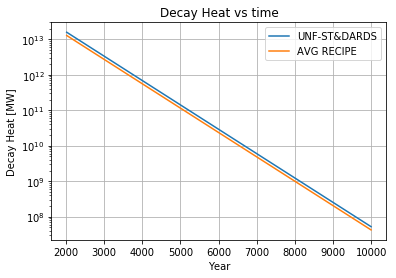

<function matplotlib.pyplot.close>

In [127]:
plt.semilogy(time_acc, heat_acc, label='UNF-ST&DARDS')
plt.semilogy(time_rec, heat_rec, label='AVG RECIPE')
plt.title('Decay Heat vs time')
plt.xlabel('Year')
plt.ylabel('Decay Heat [MW]')
plt.legend()
plt.grid()
plt.show()
plt.close

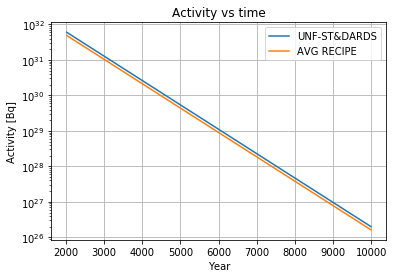

<function matplotlib.pyplot.close>

In [126]:
plt.semilogy(time_acc, act_acc, label='UNF-ST&DARDS')
plt.semilogy(time_rec, act_rec, label='AVG RECIPE')
plt.title('Activity vs time')
plt.xlabel('Year')
plt.ylabel('Activity [Bq]')
plt.legend()
plt.grid()
plt.show()
plt.close

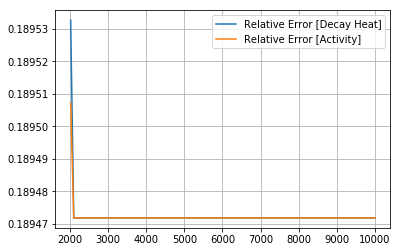

In [128]:
plt.plot(time_acc, err_heat, label='Relative Error [Decay Heat]')
plt.plot(time_acc, err_act, label='Relative Error [Activity]')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [132]:
print(decayed_lump_mat.mult_by_mass()[942390000])

520524318.7492009


# Compare isotopic differences

In [139]:
def compare_isotope(acc_mat, rec_mat, isotope_list, rel_err=False):
    # convert to canonical / pyne-standard form
    isotope_list = [nucname.id(x) for x in isotope_list]
    iso_diff_dict = {}
    for iso in isotope_list:
        acc_qty = acc_mat.mult_by_mass()[iso]
        rec_qty = rec_mat.mult_by_mass()[iso]
        if rel_err:
            iso_diff_dict[nucname.name(iso)] = (acc_qty - rec_qty) / acc_qty * 100
        else:
            iso_diff_dict[nucname.name(iso)] = acc_qty - rec_qty
    return iso_diff_dict


Text(0.5,1,'Mass Differences between Average recipe and full database')

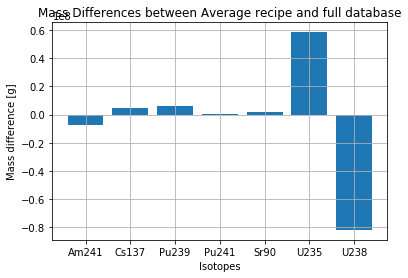

In [147]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list)
plt.bar(iso_diff_dict.keys(), iso_diff_dict.values())
plt.grid()
plt.ylabel('Mass difference [g]')
plt.xlabel('Isotopes')
plt.title('Mass Differences between Average recipe and full database')

Text(0.5,1,'Relative Error between Average recipe and full database')

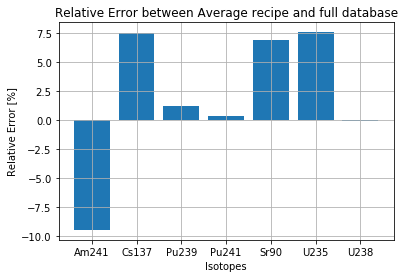

In [148]:
iso_list = ['Pu239', 'U238', 'U235', 'Am241', 'Cs137', 'Sr90', 'Pu241']
iso_diff_dict = compare_isotope(decayed_lump_mat, decayed_recipe_mat, iso_list, rel_err=True)
plt.bar(iso_diff_dict.keys(), iso_diff_dict.values())
plt.grid()
plt.ylabel('Relative Error [%]')
plt.xlabel('Isotopes')
plt.title('Relative Error between Average recipe and full database')